### 가상환경 만들기
```
pip install pipenv
pipenv --python 3.8
pipenv shell
pipenv install ipykernel
python -m ipykernel install --user --display-name test --name test
```

### 필요한 모듈 설치
```
!pip install opencv-python
!pip install matplotlib
!pip install torch
!pip install torchvision
!pip install interact
```

In [9]:
import os
import cv2
import matplotlib.pyplot as plt
import torch
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import nn
import copy

In [10]:
# data_dir: Covid19-dataset/train
# sub_dir: Normal

def list_image_file(data_dir, sub_dir):
    image_format = ['jpeg', 'jpg', 'png']
    image_files = []
    image_dir = os.path.join(data_dir, sub_dir) # Covid19-dataset/train/Normal
    for file_path in os.listdir(image_dir):
        if file_path.split('.')[-1] in image_format:
            image_files.append(os.path.join(sub_dir, file_path))
    return image_files

In [11]:
data_dir = './Covid19-dataset/train/'
normals_list = list_image_file(data_dir, 'Normal')
covids_list = list_image_file(data_dir, 'Covid')
pneumonias_list = list_image_file(data_dir, 'Viral Pneumonia')

In [12]:
print(len(normals_list))
print(len(covids_list))
print(len(pneumonias_list))

70
111
70


In [13]:
def get_RGB_image(data_dir, file_name):
    image_file = os.path.join(data_dir, file_name)
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [14]:
min_num_files = min(len(normals_list), len(covids_list), len(pneumonias_list))
min_num_files

70

In [15]:
@interact(index=(0, min_num_files-1))
def show_samples(index=0):
    normal_image = get_RGB_image(data_dir, normals_list[index])
    covid_image = get_RGB_image(data_dir, covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, pneumonias_list[index])
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(131)
    plt.title('Normal')
    plt.imshow(normal_image)
    
    plt.subplot(132)
    plt.title('Covid')
    plt.imshow(covid_image)
    
    plt.subplot(133)
    plt.title('Pneumonia')
    plt.imshow(pneumonia_image)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

In [16]:
train_data_dir = './Covid19-dataset/train/'
class_list = ['Normal', 'Covid', 'Viral Pneumonia']

In [17]:
class Chest_dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        normals = list_image_file(data_dir, 'Normal')
        covids = list_image_file(data_dir, 'Covid')
        pneumonias = list_image_file(data_dir, 'Viral Pneumonia')
        self.files_path = normals + covids + pneumonias
        self.transform = transform
        
    def __len__(self):
        return len(self.files_path)

    def __getitem__(self, index):
        image_file = os.path.join(self.data_dir, self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        target = class_list.index(self.files_path[index].split(os.sep)[-2])
         
        return {'image':image, 'target':target}

In [18]:
dset = Chest_dataset(train_data_dir)

In [19]:
len(dset)

251

In [20]:
dset[100]

{'image': array([[[  4,   4,   4],
         [  4,   4,   4],
         [  5,   5,   5],
         ...,
         [  1,   1,   1],
         [  1,   1,   1],
         [  1,   1,   1]],
 
        [[  4,   4,   4],
         [  4,   4,   4],
         [  5,   5,   5],
         ...,
         [  1,   1,   1],
         [  1,   1,   1],
         [  1,   1,   1]],
 
        [[  4,   4,   4],
         [  4,   4,   4],
         [  4,   4,   4],
         ...,
         [  1,   1,   1],
         [  1,   1,   1],
         [  1,   1,   1]],
 
        ...,
 
        [[230, 230, 230],
         [230, 230, 230],
         [230, 230, 230],
         ...,
         [121, 121, 121],
         [124, 124, 124],
         [127, 127, 127]],
 
        [[230, 230, 230],
         [230, 230, 230],
         [230, 230, 230],
         ...,
         [121, 121, 121],
         [122, 122, 122],
         [125, 125, 125]],
 
        [[232, 232, 232],
         [232, 232, 232],
         [232, 232, 232],
         ...,
         [121, 121,

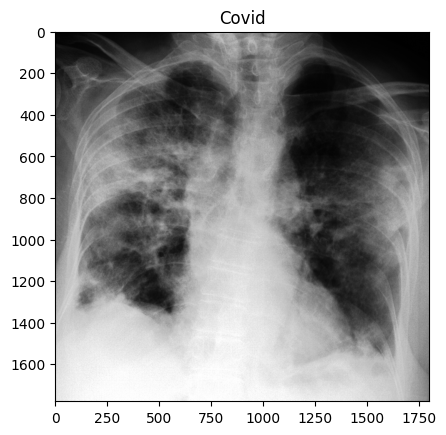

In [21]:
index = 100
plt.title(class_list[dset[index]['target']])
plt.imshow(dset[index]['image'])

In [22]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [23]:
class Chest_dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        normals = list_image_file(data_dir, 'Normal')
        covids = list_image_file(data_dir, 'Covid')
        pneumonias = list_image_file(data_dir, 'Viral Pneumonia')
        self.files_path = normals + covids + pneumonias
        self.transform = transform
        
    def __len__(self):
        return len(self.files_path)

    def __getitem__(self, index):
        image_file = os.path.join(self.data_dir, self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        target = class_list.index(self.files_path[index].split(os.sep)[-2])
        if self.transform:
            image = self.transform(image)
            target = torch.Tensor([target]).long()
         
        return {'image':image, 'target':target}

In [24]:
train_dset = Chest_dataset(train_data_dir, transformer)

In [25]:
index = 100
image = train_dset[index]['image']
label = train_dset[index]['target']
print(image.shape, label)

torch.Size([3, 224, 224]) tensor([1])


In [26]:
def build_dataloader(train_data_dir, val_data_dir):
    dataloaders = {}
    train_dset = Chest_dataset(train_data_dir, transformer)
    dataloaders['train'] = DataLoader(train_dset, batch_size=4, shuffle=True, drop_last=True)
    
    val_dset = Chest_dataset(val_data_dir, transformer)
    dataloaders['val'] = DataLoader(val_dset, batch_size=1, shuffle=False, drop_last=False)
    return dataloaders

In [27]:
train_data_dir = './Covid19-dataset/train/'
val_data_dir = './Covid19-dataset/test/'
dataloaders = build_dataloader(train_data_dir, val_data_dir)

In [28]:
for i, d in enumerate(dataloaders['train']):
    print(i, d)
    if i == 0:
        break

0 {'image': tensor([[[[-0.9192, -0.9137, -0.8821,  ..., -0.8500, -0.8787, -0.8582],
          [-0.9211, -0.8879, -0.9113,  ..., -0.8559, -0.8594, -0.8473],
          [-0.8844, -0.9070, -0.9136,  ..., -0.8727, -0.8744, -0.8752],
          ...,
          [-0.9872, -0.9843, -0.9765,  ..., -0.8968, -0.8823, -0.8588],
          [-0.9686, -0.9922, -0.9697,  ..., -0.8654, -0.8694, -0.8989],
          [-0.9843, -0.9551, -0.9895,  ..., -0.8678, -0.8811, -0.8597]],

         [[-0.9192, -0.9137, -0.8821,  ..., -0.8500, -0.8787, -0.8582],
          [-0.9211, -0.8879, -0.9113,  ..., -0.8559, -0.8594, -0.8473],
          [-0.8844, -0.9070, -0.9136,  ..., -0.8727, -0.8744, -0.8752],
          ...,
          [-0.9872, -0.9843, -0.9765,  ..., -0.8968, -0.8823, -0.8588],
          [-0.9686, -0.9922, -0.9697,  ..., -0.8654, -0.8694, -0.8989],
          [-0.9843, -0.9551, -0.9895,  ..., -0.8678, -0.8811, -0.8597]],

         [[-0.9192, -0.9137, -0.8821,  ..., -0.8500, -0.8787, -0.8582],
          [-0.9211

In [29]:
d['target'].shape

torch.Size([4, 1])

### VGG19(Classification) 모델 불러오기
* VGG는 Visual Geometry Group의 약자
* 다중 레이어가 있는 표준 심층 CNN 아키텍처

<img src="https://wikidocs.net/images/page/164796/vgg_Fig_01.png" width="500px">

In [30]:
# torchvision의 models 사용
# pretrained=True: 미리 학습된 weight들을 가지고 옴(전이학습)
model = models.vgg19(pretrained=True)

In [31]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [32]:
def build_vgg19_based_model(device_name='cpu'):
    device = torch.device(device_name)
    model = models.vgg19(pretrained=True)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, len(class_list)),
        nn.Softmax(dim=1)
    )
    return model.to(device)

In [33]:
model = build_vgg19_based_model(device_name='cpu')

In [34]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [35]:
loss_func = nn.CrossEntropyLoss(reduction='mean')

In [36]:
optimizer = torch.optim.SGD(model.parameters(), lr=1E-3, momentum=0.9)

In [37]:
@torch.no_grad()
def get_accuracy(image, target, model):
    batch_size = image.shape[0]
    prediction = model(image)
    _, pred_label = torch.max(prediction, dim=1)
    is_correct = (pred_label == target)
    return is_correct.cpu().numpy().sum() / batch_size

In [38]:
def train_one_epoch(dataloaders, model, optimizer, loss_func, device):
    losses = {}
    accuracies = {}
    
    for tv in ['train', 'val']:
        running_loss = 0.0
        running_correct = 0
        
        if tv == 'train':
            model.train()
        else:
            model.eval()
        
        for index, batch in enumerate(dataloaders[tv]):
            image = batch['image'].to(device)
            target = batch['target'].squeeze(dim=1).to(device)
            
            with torch.set_grad_enabled(tv == 'train'):
                prediction = model(image)
                loss = loss_func(prediction, target)
                
                if tv == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            
            running_loss += loss.item()
            running_correct += get_accuracy(image, target, model)
            
            if tv == 'train':
                if index % 10 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")

        losses[tv] = running_loss / len(dataloaders[tv])
        accuracies[tv] = running_correct / len(dataloaders[tv])
    return losses, accuracies          

In [39]:
def save_best_model(model_state, model_name, save_dir='./trained_model'):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))

In [40]:
device = torch.device('cpu')

train_data_dir = './Covid19-dataset/train/'
val_data_dir = './Covid19-dataset/test/'
dataloaders = build_dataloader(train_data_dir, val_data_dir)
model = build_vgg19_based_model(device_name=device)
loss_func = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=1E-3, momentum=0.9)

In [35]:
num_epochs = 10
best_acc = 0.0
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []

for epoch in range(num_epochs):
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_accuracy.append(accuracies['train'])
    val_accuracy.append(accuracies['val'])
    
    print(f"{epoch+1}/{num_epochs} - Train_Loss:{losses['train']}, Val_Loss:{losses['val']}")
    print(f"{epoch+1}/{num_epochs} - Train_Accuracies:{accuracies['train']}, Val_Accuracies:{accuracies['val']}")
    
    if(epoch > 3) and (accuracies['val'] > best_acc):
          best_acc = accuracies['val']
          best_model = copy.deepcopy(model.state_dict())
          save_best_model(best_model, f'model_{epoch+1:02d}.pth')

print(f'Best Accuracy: {best_acc}')

0/62 - Running loss: 0.6596444845199585
10/62 - Running loss: 0.7174469828605652
20/62 - Running loss: 0.5547822117805481
30/62 - Running loss: 0.6929032802581787
40/62 - Running loss: 0.5661619305610657
50/62 - Running loss: 0.5629227757453918
60/62 - Running loss: 0.551482617855072
1/10 - Train_Loss:0.6814165576811759, Val_Loss:0.8718155812133442
1/10 - Train_Accuracies:0.9153225806451613, Val_Accuracies:0.6666666666666666
0/62 - Running loss: 0.9134337902069092
10/62 - Running loss: 0.6041631698608398
20/62 - Running loss: 0.5541736483573914
30/62 - Running loss: 0.7982907295227051
40/62 - Running loss: 0.5534658432006836
50/62 - Running loss: 0.5924592018127441
60/62 - Running loss: 0.5525867342948914
2/10 - Train_Loss:0.6514622030719635, Val_Loss:0.6896341262441693
2/10 - Train_Accuracies:0.9314516129032258, Val_Accuracies:0.8636363636363636
0/62 - Running loss: 0.5516114830970764
10/62 - Running loss: 0.5690373778343201
20/62 - Running loss: 0.5514503121376038
30/62 - Running los

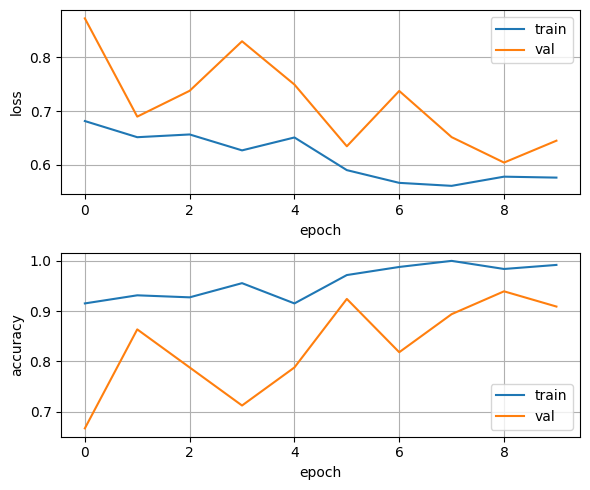

In [36]:
plt.figure(figsize=(6, 5))
plt.subplot(211)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid('on')
plt.legend()
plt.subplot(212)
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid('on')
plt.legend()
plt.tight_layout()

In [41]:
def preprocess_image(image):
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    tensor_image = transformer(image) # C, H, W
    tensor_image = tensor_image.unsqueeze(0) # B, C, H, W
    return tensor_image

In [42]:
def model_predict(image, model):
    tensor_image = preprocess_image(image)
    prediction = model(tensor_image)
    
    _, pred_label = torch.max(prediction.detach(), dim=1)
    print('prediction.detach(): ',prediction.detach())
    print('pred_label: ', pred_label)
    pred_label = pred_label.squeeze(0)
    return pred_label.item()

In [43]:
ckpt = torch.load('./trained_model/model_09.pth')
model = build_vgg19_based_model()
model.load_state_dict(ckpt)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [44]:
data_dir = './Covid19-dataset/test/'
test_normals_list = list_image_file(data_dir, 'Normal')
test_covids_list = list_image_file(data_dir, 'Covid')
test_pneumonias_list = list_image_file(data_dir, 'Viral Pneumonia')
class_list = ['Normal', 'Covid', 'Viral Pneumonia']

In [46]:
min_num_files = min(len(test_normals_list), len(test_covids_list), len(test_pneumonias_list))

@interact(index=(0, min_num_files-1))
def show_samples(index=0):
    normal_image = get_RGB_image(data_dir, test_normals_list[index])
    covid_image = get_RGB_image(data_dir, test_covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, test_pneumonias_list[index])
    
    prediction_1 = model_predict(normal_image, model)
    prediction_2 = model_predict(covid_image, model)
    prediction_3 = model_predict(pneumonia_image, model)
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(131)
    plt.title(f'Normal, Pred:{class_list[prediction_1]}')
    plt.imshow(normal_image)
    
    plt.subplot(132)
    plt.title(f'Covid, Pred:{class_list[prediction_2]}')
    plt.imshow(covid_image)
    
    plt.subplot(133)
    plt.title(f'Pneumonia, Pred:{class_list[prediction_3]}')
    plt.imshow(pneumonia_image)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=19), Output()), _dom_classes=('widget-intera…